# Task 2c - Topic Modeling LDA

# Imports

In [319]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from pprint import pprint
from collections import Counter


In [320]:
df = pd.read_json('Sports_and_Outdoors_5.json',lines = True)

In [321]:
# Laden der Pickle Datei mit dem POC-Datensatz auf den bereits Data Cleaning betrieben wurde
#df_poc = pd.read_pickle('poc.pkl')

# Topic Modelling - LDA

Bei der Latent Direchlet Allocation handelt es sich um einen Algoeithmus zum Topic Modeling. Dafür wird angenommen, dass jedes Dokument aus einer Mischung von verschiedenen Themen besteht, jedes mit entsprechender Gewichtung. Jedes Wort in einem Dokument wird einen Thema zugeordnet.
Damit besteht ein Thema aus einer Mischung aus Wörtern, ebenfalls mit entsprechender Gewichtung.

Ein Wort kann dabei in mehreren Themen auftauchen, da es sich immer um eine Wahrscheinlichkeit des Auftauchen eines Wortes handelt.

Es werden also die Verteilung von Wort-Thema und Thema-Dokument berechnet und diese werden genutzt um latente, vorhandene aber noch nicht sichtbare, Themen in einen Dokument zu finden.

# POC - Beispieldatensatz 

Für das erste Modell wird nur 1% des Datensatzes genutzt um die Funktionalität der Pipeline zu prüfen. Dies entspricht 28399 Reviews.

In [322]:
# Für Testzwecke werden nur 1% des Datensatzes betrachtet: 28399 Zeilen
df_poc = df.sample(frac=0.01, replace=False, random_state=1)
df_poc = df_poc[['reviewerID', 'unixReviewTime' ,'asin', 'overall', 'reviewText']]
df_poc.shape

(28399, 5)

## Data Cleaning
Um die Daten später in ein LDA Model anwenden zu können, müssen diese entsprechen gesäubert und transformiert werden:
- Text wird kleingeschrieben
- Sonderzeichen werden entfernt
- Text wird Tokenized (jedes Wort wird ein Element in einer Liste)
- Stopwörte entfernen
- Lemmatization

In [323]:
def clean_text(df):

    # Text kleinschreiben
    df['reviewText'] = df['reviewText'].astype(str).str.lower()

    # Textzeichen entfernen
    df['reviewText'] = df['reviewText'].map(lambda x: re.sub(r'[,\.!?]','', x))

    # Tokenizen
    regexp = RegexpTokenizer(r'\w+')
    df['reviewText_tokenize']=df['reviewText'].apply(regexp.tokenize)  
    
    # Stopwörter entfernen 
    stopwords = nltk.corpus.stopwords.words("english")
    df['reviewText_tokenize'] = df['reviewText_tokenize'].apply(lambda x: [i for i in x if i not in stopwords])

    # Lemmatization
    lemma_list = []
    lem = WordNetLemmatizer()

    for row in df['reviewText_tokenize']:
        holder = []
        for elem in row:
            holder.append(lem.lemmatize(elem, "v"))
        lemma_list.append(holder)

    df['reviewText_tokenize'] = lemma_list


Nach dem Data Cleaning wird die neue Spalte 'reviewText_tokenize' erstellt, welche die gesäuberten Wörter in einer Liste abspeichert.

In [324]:
clean_text(df_poc)
df_poc.head()

,reviewerID,unixReviewTime,asin,overall,reviewText,reviewText_tokenize
1195218,A36JK2BSXS0U43,1517788800,B005NATM06,5,we are reviewing several sets of darts from vi...,"[review, several, set, dart, viper, learn, gam..."
138622,A374H5DSRDUT1P,1408147200,B000F7VV42,5,perfect,[perfect]
45540,AU52E1PVI59D0,1462060800,B00070QEN0,2,just lost another one - again would someone p...,"[lose, another, one, would, someone, please, m..."
1893937,A2TM7I63LF51L1,1487289600,B00M8MLSJ0,5,works good,"[work, good]"
1914910,AXCRLIMPYXWUG,1467072000,B00MX89O2C,3,i got this lock because its a small size so it...,"[get, lock, small, size, lighter, use, want, l..."


Für das spätere Topic Modeling könnte es interessant sein, nur die Substative, Verben oder Adjektive von einem Text zu betrachten. Dafür wird das Natural Language Toolkit NLTK genutzt, welches Funktionen anbietet um für jedes Wort sein 'Part of Speech' zu erkennen.

In [325]:
def get_adjectives(text):
    pos = nltk.pos_tag(text)
    adj = []
    for elem in pos:
        # print(elem)
        if elem[1] not in ['NN', 'NNS', 'NNP', 'NNPS', 'VBZ', 'VBP', 'VBN', 'VBG', 'VBD', 'VB']:
            adj.append(elem[0])
    # print()
    return adj

def get_nouns(text):
    pos = nltk.pos_tag(text)
    noun = []
    for elem in pos:
        # print(elem)
        if elem[1] in ['NN', 'NNS', 'NNP', 'NNPS']:
            noun.append(elem[0])
    # print()
    return noun

def get_verbs(text):
    pos = nltk.pos_tag(text)
    ver = []
    for elem in pos:
        # print(elem)
        if elem[1] in ['VBZ', 'VBP', 'VBN', 'VBG', 'VBD', 'VB']:
            ver.append(elem[0])
    # print()
    return ver

In [326]:
df_poc['adjectives'] = df_poc['reviewText_tokenize'].apply(get_adjectives)
df_poc['nouns'] = df_poc['reviewText_tokenize'].apply(get_nouns)
df_poc['verbs'] = df_poc['reviewText_tokenize'].apply(get_verbs)

In [327]:
# Abspeichern der Ergebnisse nach dem Cleaning
# df_poc.to_pickle('poc.pkl')

Nochmal ein Blick auf den fertig aufbereiteten Datensatz. Die neuen Spalten sind:
- reviewText_tokenize - Schlüsselwörter von reviewText als Liste
- adjectives - nur Adjektive von reviewText als Liste
- nouns - nur Substantive von reviewText als Liste
- verbs - nur Verben von reviewText als Liste

In [328]:
df_poc.head()

,reviewerID,unixReviewTime,asin,overall,reviewText,reviewText_tokenize,adjectives,nouns,verbs
1195218,A36JK2BSXS0U43,1517788800,B005NATM06,5,we are reviewing several sets of darts from vi...,"[review, several, set, dart, viper, learn, gam...","[several, dart, non, pro, tip, awkward, comfor...","[viper, learn, game, husband, use, play, leagu...","[review, set, hold, say, want]"
138622,A374H5DSRDUT1P,1408147200,B000F7VV42,5,perfect,[perfect],[],[perfect],[]
45540,AU52E1PVI59D0,1462060800,B00070QEN0,2,just lost another one - again would someone p...,"[lose, another, one, would, someone, please, m...","[another, would, lanyard, buoyant, around, sin...","[one, someone, material, wire, work, clip, use...","[lose, please, make, make, cheapest]"
1893937,A2TM7I63LF51L1,1487289600,B00M8MLSJ0,5,works good,"[work, good]",[good],[work],[]
1914910,AXCRLIMPYXWUG,1467072000,B00MX89O2C,3,i got this lock because its a small size so it...,"[get, lock, small, size, lighter, use, want, l...","[lock, small, bike, forever, lock, one, right,...","[size, lighter, use, lock, frame, rack, work, ...","[get, want, take, get, go, find]"


## Training des Models - LatentDirichletAllocation

Für dieses Modell wird für jedes Dokument als Input ein String benötigt anstatt einer Liste von Wörtern. Deswegen wird in 'reviewText_cleaned' die Liste als String abgespeichert.

In [329]:
def token2string(tokens):
    erg = " ".join(tokens)
    return erg
df_poc['reviewText_cleaned'] = df_poc['reviewText_tokenize'].apply(token2string)

Tfidf - Term Frequency Inverse Document Frequency: vergleicht die Häufigkeit an Wörtern mit der Anzahl an Dokumenten, welche das Wort enthalten.

In [330]:
vect = TfidfVectorizer()
vect_text=vect.fit_transform(df_poc['reviewText_cleaned'])

In [331]:
lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', random_state=1) 
lda_top = lda_model.fit_transform(vect_text)

In [332]:
for x in range(3):
  print(x+1,". Reviewtext: ", df_poc.iloc[x]['reviewText'])
  for i,topic in enumerate(lda_top[x]):
    print("Thema ",i,": ",topic*100,"%")
  print()

1 . Reviewtext:  we are reviewing several sets of darts from viper  i am just learning the game and my husband used to play in a non-pro league  the blitz steel tips are awkward for me to hold comfortably because they are so streamlined but to him these are now his new favorites  he says they do exactly what he wants he loves the weight and slimness that viper has created here these are "serious" darts for the more advanced player
Thema  0 :  26.42497808561349 %
Thema  1 :  3.2765930434143766 %
Thema  2 :  3.3364007631194093 %
Thema  3 :  6.480789470790296 %
Thema  4 :  60.48123863706242 %

2 . Reviewtext:  perfect
Thema  0 :  10.000006098898522 %
Thema  1 :  10.000010369607276 %
Thema  2 :  59.971827907572475 %
Thema  3 :  10.000006983671312 %
Thema  4 :  10.02814864025041 %

3 . Reviewtext:  just lost another one - again  would someone please make these with a lanyard or a buoyant material around the wire  it works but since i lose so many nose clips it makes more since to use the ch

In [333]:
vocab = vect.get_feature_names_out()
for i, comp in enumerate(lda_model.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:5]
     print("Thema "+str(i)+": ")
     for t in sorted_words:
            print(t[0],end=" ")
            # print("")
     print('')

Thema 0: 
knife advertise scope target sight 
Thema 1: 
gift shirt cute soccer em 
Thema 2: 
love perfect nice thank fit 
Thema 3: 
great good work product excellent 
Thema 4: 
great use well work like 


## Training des Modells - LdaMulticore
Der LDA Algorithmus von dem Paket sklearn nutzt nur einen Kern des Prozessors für die Berechnung. Dies führ dazu, dass die Berechnung von 1% des Datensatzes bereits 10 Minuten braucht. Ein effizenteres Modell wäre LdaMulticore von Gensim. Dieses nutzt mehrere Kerne des Prozessors wodurch die Berechnungen parallel zueinander laufen können. Im Test hat der Durchlauf dann auch nur einen Bruchteil einer Sekunde gebraucht.

| Algorithmus               | Zeilen | Berechnungszeit |  
|---------------------------|--------|-----------------|
| LatentDirichletAllocation | 28399 | 10 Minutes      |  
| LdaMulticore              | 28399 | 0.3 Minutes     | 


Zuerst werden alle Listen von Schlüsselwörtern der einzelnen Dokumente in eine Liste (data) hinzugefügt. Basierend darauf wird ein corpora.dictionary erstellt. Hier wird jedem Wort eine Id zugewiesen. 

In [334]:
data = df_poc.reviewText_tokenize.values.tolist()

Das corpora.Dictionary wird in eine Liste umkonvertiert, welches für jeden Text eine Liste aus Tupeln beinhaltet. Jedes Tupel besteht dabei aus der TokenId und der Anzahl der Vorkommen dieser Id.

In [335]:
id2word = corpora.Dictionary(data)

#id2word.token2id   # print Dictionary
#id2word.cfs        # frequency of ids
#id2word.num_docs   # number of documents - hier: Zeilen im Dataframe
#id2word.num_pos    # number of processed words

corpus = [id2word.doc2bow(elem) for elem in data]

- corpus: Liste mit Listen von Tupel (TokenId, Anzahl der Vorkommen)
- id2word: Mapping von ID der Wörter zu Wörter
- num_topics: Anzahl an Themen welche erstellt werden sollen

In [336]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=5)


## Untersuchung der Ergebnisse

Für den ersten Blick werden die ersten drei Texte gedruckt und deren zugehörigen Anteile von Themen.

In [337]:
def print_text_topic(df, lda_model, id2word, num):
    for i in range(num):
        bow = id2word.doc2bow(df.iloc[i]['reviewText_tokenize'])
        docu_topics = lda_model.get_document_topics(bow)

        print(i+1,'. Reviewtext: ', df.iloc[i]['reviewText'])
        for top in docu_topics:
            print('Thema ',top[0],': ', top[1]*100,'%')
        print()

print_text_topic(df_poc, lda_model, id2word, 3)

1 . Reviewtext:  we are reviewing several sets of darts from viper  i am just learning the game and my husband used to play in a non-pro league  the blitz steel tips are awkward for me to hold comfortably because they are so streamlined but to him these are now his new favorites  he says they do exactly what he wants he loves the weight and slimness that viper has created here these are "serious" darts for the more advanced player
Thema  2 :  39.24567401409149 %
Thema  3 :  50.12723207473755 %
Thema  4 :  9.45027843117714 %

2 . Reviewtext:  perfect
Thema  0 :  10.28885468840599 %
Thema  1 :  10.079541802406311 %
Thema  2 :  59.27603244781494 %
Thema  3 :  10.201019793748856 %
Thema  4 :  10.1545549929142 %

3 . Reviewtext:  just lost another one - again  would someone please make these with a lanyard or a buoyant material around the wire  it works but since i lose so many nose clips it makes more since to use the cheapest one that works - not this
Thema  0 :  96.71302437782288 %



In [338]:
lda_model.print_topics(5, 20)

[(0,
  '0.015*"well" + 0.012*"great" + 0.010*"work" + 0.009*"make" + 0.009*"use" + 0.009*"one" + 0.008*"bag" + 0.008*"fit" + 0.008*"love" + 0.007*"get" + 0.007*"like" + 0.007*"need" + 0.006*"good" + 0.006*"much" + 0.005*"keep" + 0.005*"buy" + 0.004*"knife" + 0.004*"better" + 0.004*"quality" + 0.004*"water"'),
 (1,
  '0.022*"use" + 0.013*"work" + 0.012*"great" + 0.011*"get" + 0.011*"good" + 0.009*"product" + 0.007*"one" + 0.007*"well" + 0.007*"buy" + 0.007*"time" + 0.006*"make" + 0.006*"price" + 0.005*"like" + 0.005*"love" + 0.005*"go" + 0.005*"come" + 0.004*"need" + 0.004*"quality" + 0.004*"would" + 0.004*"take"'),
 (2,
  '0.012*"great" + 0.010*"would" + 0.010*"use" + 0.009*"like" + 0.009*"fit" + 0.009*"one" + 0.008*"work" + 0.008*"buy" + 0.007*"get" + 0.006*"well" + 0.006*"time" + 0.006*"make" + 0.006*"size" + 0.006*"bike" + 0.005*"light" + 0.005*"put" + 0.005*"good" + 0.005*"perfect" + 0.005*"product" + 0.004*"bag"'),
 (3,
  '0.017*"great" + 0.015*"use" + 0.011*"good" + 0.011*"get" +

### Normalisierung
Um zu prüfen, welche Wörter bei welchen Thema den stärksten Einfluss haben, sollen die Zahlen normiert werden. Über die Methode get_topic_terms wird für das gegebene Thema eine Liste mit Tupeln erstellt, welche die Id eines Wortes sowie desen Wert beinhaltet.

In [339]:
topic_zero = lda_model.get_topic_terms(0, 20)
topic_one = lda_model.get_topic_terms(1, 20)
topic_two = lda_model.get_topic_terms(2, 20)
topic_three = lda_model.get_topic_terms(3, 20)
topic_four = lda_model.get_topic_terms(4, 20)

topic_zero


[(155, 0.014773757),
 (262, 0.011736456),
 (49, 0.010088598),
 (40, 0.00927833),
 (28, 0.009038642),
 (44, 0.008706187),
 (160, 0.008413656),
 (56, 0.008093723),
 (13, 0.0077996124),
 (60, 0.0073819384),
 (263, 0.006844423),
 (240, 0.0065828236),
 (51, 0.0064272215),
 (67, 0.0059461775),
 (189, 0.0053895335),
 (161, 0.0050977706),
 (1206, 0.0043455227),
 (103, 0.004019929),
 (143, 0.0038776605),
 (376, 0.0036612933)]

Diese Listen sollen jetzt in ein Dataframe gespeichert werden, mit den Id der Wörter als Spalten Labels und die Themen als Reihen Labels. Dafür werden die Listen mit Tupel in Dictionarys umgewandelt.

In [340]:
dic_list = []
for elem in [topic_zero, topic_one, topic_two, topic_three, topic_four]:
    dic = dict((x,y) for x,y in elem)
    dic_list.append(dic)
dic_list[0]


{155: 0.014773757,
 262: 0.011736456,
 49: 0.010088598,
 40: 0.00927833,
 28: 0.009038642,
 44: 0.008706187,
 160: 0.008413656,
 56: 0.008093723,
 13: 0.0077996124,
 60: 0.0073819384,
 263: 0.006844423,
 240: 0.0065828236,
 51: 0.0064272215,
 67: 0.0059461775,
 189: 0.0053895335,
 161: 0.0050977706,
 1206: 0.0043455227,
 103: 0.004019929,
 143: 0.0038776605,
 376: 0.0036612933}

In [341]:
df_topic = pd.DataFrame.from_records(dic_list)
df_topic

,155,262,49,40,28,44,160,56,13,60,...,131,244,32,162,275,478,9,30,276,525
0,0.014774,0.011736,0.010089,0.009278,0.009039,0.008706,0.008414,0.008094,0.007800,0.007382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.006909,0.012127,0.013018,0.006326,0.021883,0.007226,NaN,NaN,0.004891,0.011316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.006441,0.012050,0.007764,0.005851,0.009782,0.009071,0.004438,0.009187,NaN,0.006853,...,0.005227,0.004802,0.004773,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.006435,0.017052,0.010166,0.004995,0.015323,0.007441,NaN,0.009493,NaN,0.010538,...,0.004460,NaN,NaN,0.005718,0.005538,0.005132,0.003962,0.003938,NaN,NaN
4,0.006461,0.010473,0.006179,0.008107,0.011397,0.006749,NaN,NaN,0.006826,0.010823,...,NaN,NaN,NaN,NaN,0.004685,0.007139,NaN,NaN,0.00938,0.005911


Um die Lesbarkeit zu verbessern werden die Wörter-Ids durch die tatsächlichen Wörter ersetzt.

In [342]:
words = []
for elem in df_topic.columns:
    words.append(id2word.get(elem))
df_topic.columns = words

df_topic

,well,great,work,make,use,one,bag,fit,love,get,...,light,put,perfect,easy,little,look,hold,want,nice,really
0,0.014774,0.011736,0.010089,0.009278,0.009039,0.008706,0.008414,0.008094,0.007800,0.007382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.006909,0.012127,0.013018,0.006326,0.021883,0.007226,NaN,NaN,0.004891,0.011316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.006441,0.012050,0.007764,0.005851,0.009782,0.009071,0.004438,0.009187,NaN,0.006853,...,0.005227,0.004802,0.004773,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.006435,0.017052,0.010166,0.004995,0.015323,0.007441,NaN,0.009493,NaN,0.010538,...,0.004460,NaN,NaN,0.005718,0.005538,0.005132,0.003962,0.003938,NaN,NaN
4,0.006461,0.010473,0.006179,0.008107,0.011397,0.006749,NaN,NaN,0.006826,0.010823,...,NaN,NaN,NaN,NaN,0.004685,0.007139,NaN,NaN,0.00938,0.005911


In [343]:
df_topic = df_topic.replace(np.nan, 0)
for elem in df_topic.columns:
    df_topic[elem] = (df_topic[elem] - df_topic[elem].min()) / (df_topic[elem].max() - df_topic[elem].min())    

df_topic

,well,great,work,make,use,one,bag,fit,love,get,...,light,put,perfect,easy,little,look,hold,want,nice,really
0,1.000000,0.192051,0.571706,1.000000,0.000000,0.842937,1.000000,0.852636,1.000000,0.118588,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
1,0.056778,0.251340,1.000000,0.310652,1.000000,0.205585,0.000000,0.000000,0.627112,1.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
2,0.000634,0.239685,0.231797,0.199699,0.057846,1.000000,0.527514,0.967779,0.000000,0.000000,...,1.000000,1.0,1.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
3,0.000000,1.000000,0.583079,0.000000,0.489293,0.297831,0.000000,1.000000,0.000000,0.825729,...,0.853274,0.0,0.0,1.0,1.000000,0.71879,1.0,1.0,0.0,0.0
4,0.003135,0.000000,0.000000,0.726619,0.183601,0.000000,0.000000,0.000000,0.875213,0.889641,...,0.000000,0.0,0.0,0.0,0.846107,1.00000,0.0,0.0,1.0,1.0


In [344]:
for i in range(5):
    print('Thema ',i)
    print(df_topic.loc[df_topic.index[i]].loc[lambda x : x == 1])
    print()


Thema  0
well      1.0
make      1.0
bag       1.0
love      1.0
need      1.0
much      1.0
keep      1.0
knife     1.0
better    1.0
Name: 0, dtype: float64

Thema  1
work       1.0
use        1.0
get        1.0
product    1.0
time       1.0
price      1.0
come       1.0
take       1.0
Name: 1, dtype: float64

Thema  2
one        1.0
buy        1.0
would      1.0
size       1.0
bike       1.0
light      1.0
put        1.0
perfect    1.0
Name: 2, dtype: float64

Thema  3
great      1.0
fit        1.0
good       1.0
quality    1.0
easy       1.0
little     1.0
hold       1.0
want       1.0
Name: 3, dtype: float64

Thema  4
like      1.0
water     1.0
go        1.0
look      1.0
nice      1.0
really    1.0
Name: 4, dtype: float64



In [345]:
# for col in df_topic.columns:
#     print(col,' ' ,len(df_topic[col].unique()))
# df_nan = df_topic[df_topic.columns[~df_topic.isnull().any()]]

### Bestimmung des Hauptthemas

In [346]:
# Save Main Topic in seperate column
def maintopic(df, lda_model):
    scores = []
    topic = []

    counter = 0

    #Iteration über alle Dokumente
    for elem in df['reviewText_tokenize']:
        bow = id2word.doc2bow(elem)
        docu_topics = lda_model.get_document_topics(bow)
        topic_scores = []
        topic_number = []
        # alle Topics von einen Dokument in eine Liste abspeichern
        for elem in docu_topics:
            topic_scores.append(elem[1])
            topic_number.append(elem[0])
        main_score = max(topic_scores)
        main_topic = topic_number[topic_scores.index(main_score)]

        scores.append(main_score)
        topic.append(main_topic)

        # print(topic_scores)
        # print(topic_number)

        # print(scores)
        # print(topic)

    df['maintopic'] = topic
    df['mainscore'] = scores
    # return res

In [347]:
maintopic(df_poc, lda_model)

In [348]:
df_poc.head()

,reviewerID,unixReviewTime,asin,overall,reviewText,reviewText_tokenize,adjectives,nouns,verbs,reviewText_cleaned,maintopic,mainscore
1195218,A36JK2BSXS0U43,1517788800,B005NATM06,5,we are reviewing several sets of darts from vi...,"[review, several, set, dart, viper, learn, gam...","[several, dart, non, pro, tip, awkward, comfor...","[viper, learn, game, husband, use, play, leagu...","[review, set, hold, say, want]",review several set dart viper learn game husba...,3,0.511848
138622,A374H5DSRDUT1P,1408147200,B000F7VV42,5,perfect,[perfect],[],[perfect],[],perfect,2,0.592782
45540,AU52E1PVI59D0,1462060800,B00070QEN0,2,just lost another one - again would someone p...,"[lose, another, one, would, someone, please, m...","[another, would, lanyard, buoyant, around, sin...","[one, someone, material, wire, work, clip, use...","[lose, please, make, make, cheapest]",lose another one would someone please make lan...,0,0.967138
1893937,A2TM7I63LF51L1,1487289600,B00M8MLSJ0,5,works good,"[work, good]",[good],[work],[],work good,1,0.726865
1914910,AXCRLIMPYXWUG,1467072000,B00MX89O2C,3,i got this lock because its a small size so it...,"[get, lock, small, size, lighter, use, want, l...","[lock, small, bike, forever, lock, one, right,...","[size, lighter, use, lock, frame, rack, work, ...","[get, want, take, get, go, find]",get lock small size lighter use want lock fram...,3,0.982898


Fürs erste soll die Verteilung der Themen betrachtet werden.
!-- Erkenntnisse

In [349]:
df_poc['maintopic'].value_counts().sort_index()

0    4486
1    5636
2    6317
3    5568
4    6392
Name: maintopic, dtype: int64

### Wertebereiche von mainscores
Wie im Histogram zu sehen ist, haben die meisten Dokumente einen Score von 0.7 und höher.
Wenn der Mainscore nahe an 0.2 liegt, dann bedeutet dies, dass die Themen im Dokument sehr gleichmäßig verteilt sind. Diese könnten für die weitere Analyse entfernt werden, weil diese nicht sehr aussagekrägtig für ein Thema sind.

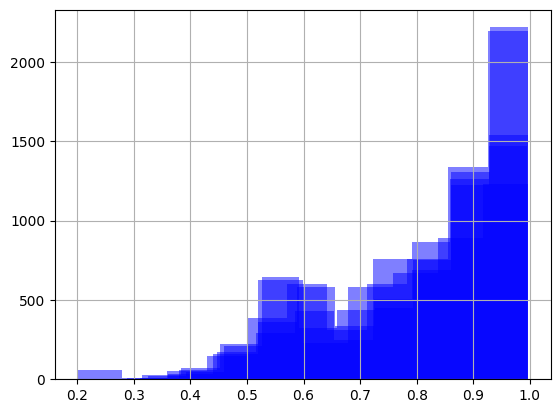

In [350]:
def transparent_histogram(df):
    for i in range(5):
        a = df.loc[df['maintopic'] == i, 'mainscore']
        a.sort_values()
        #a.hist()
        a.hist(fc=(0, 0, 1, 0.5))

transparent_histogram(df_poc)

### Betrachtung von MainTopic - Overall

In [351]:
df_poc.head()

,reviewerID,unixReviewTime,asin,overall,reviewText,reviewText_tokenize,adjectives,nouns,verbs,reviewText_cleaned,maintopic,mainscore
1195218,A36JK2BSXS0U43,1517788800,B005NATM06,5,we are reviewing several sets of darts from vi...,"[review, several, set, dart, viper, learn, gam...","[several, dart, non, pro, tip, awkward, comfor...","[viper, learn, game, husband, use, play, leagu...","[review, set, hold, say, want]",review several set dart viper learn game husba...,3,0.511848
138622,A374H5DSRDUT1P,1408147200,B000F7VV42,5,perfect,[perfect],[],[perfect],[],perfect,2,0.592782
45540,AU52E1PVI59D0,1462060800,B00070QEN0,2,just lost another one - again would someone p...,"[lose, another, one, would, someone, please, m...","[another, would, lanyard, buoyant, around, sin...","[one, someone, material, wire, work, clip, use...","[lose, please, make, make, cheapest]",lose another one would someone please make lan...,0,0.967138
1893937,A2TM7I63LF51L1,1487289600,B00M8MLSJ0,5,works good,"[work, good]",[good],[work],[],work good,1,0.726865
1914910,AXCRLIMPYXWUG,1467072000,B00MX89O2C,3,i got this lock because its a small size so it...,"[get, lock, small, size, lighter, use, want, l...","[lock, small, bike, forever, lock, one, right,...","[size, lighter, use, lock, frame, rack, work, ...","[get, want, take, get, go, find]",get lock small size lighter use want lock fram...,3,0.982898


In [352]:
def print_avg_overall_for_maintopic(df):
    for i in range(5):
        avg = df.loc[df['maintopic'] == i, 'overall'].mean()
        print('Thema ',i, ' hat eine durchschnittliche Bewertung von ', avg)
print_avg_overall_for_maintopic(df_poc)

Thema  0  hat eine durchschnittliche Bewertung von  4.515827017387427
Thema  1  hat eine durchschnittliche Bewertung von  4.372427253371185
Thema  2  hat eine durchschnittliche Bewertung von  4.357131549786291
Thema  3  hat eine durchschnittliche Bewertung von  4.48742816091954
Thema  4  hat eine durchschnittliche Bewertung von  4.337453066332916


Die Unterschiede zwischen den Durchschnittswerten ist minimal, kann aber bei weiteren Fällen nochmal betrachtet werden.

In [353]:
def print_proportion_overall(df):
    for i in range(5):
        print('Thema ',i)
        counts = df.loc[df['maintopic'] == i, 'overall'].value_counts()
        low = counts[1]/counts.sum()
        high = counts[5]/counts.sum()
        # print(df.loc[df['maintopic'] == i, 'overall'].value_counts().sum())
        print('Anteil von 1*: ',low*100,'%')
        print('Anteil von 5*: ',high*100,'%')
        
print_proportion_overall(df_poc)

Thema  0
Anteil von 1*:  2.942487739634418 %
Anteil von 5*:  72.2246990637539 %
Thema  1
Anteil von 1*:  5.0745209368346345 %
Anteil von 5*:  67.902767920511 %
Thema  2
Anteil von 1*:  4.701598860218458 %
Anteil von 5*:  65.66408105113186 %
Thema  3
Anteil von 1*:  3.3045977011494254 %
Anteil von 5*:  70.61781609195403 %
Thema  4
Anteil von 1*:  4.005006257822278 %
Anteil von 5*:  63.21964956195244 %


Die Unterschiede sind auch hier minimal. Ein direkter Zusammenhang zwischen Topic und Bewertung scheint es nicht zu geben.

### Visualisierung mit pyLDAavis

In [354]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

c:\Users\Ha Mi Duong\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.002606  0.005175       1        1  27.702886
4     -0.008082  0.023669       2        1  23.387320
1      0.017859 -0.010135       3        1  19.072693
3      0.016620 -0.001468       4        1  16.239383
0     -0.023790 -0.017241       5        1  13.597718, topic_info=        Term         Freq        Total Category  logprob  loglift
155     well  5174.000000  5174.000000  Default  30.0000  30.0000
28       use  8953.000000  8953.000000  Default  29.0000  29.0000
160      bag  2455.000000  2455.000000  Default  28.0000  28.0000
353  product  3106.000000  3106.000000  Default  27.0000  27.0000
49      work  6142.000000  6142.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
61        go   320.243944  3087.276570   Topic5  -5.6580  -0.2707
50     would   334.565046  4201.461932   Topic5  -5.6143  -0.5351
162     easy   288.992875  2590.997040   Topic5  -5.7607  -0.1981
9       hold   272.896988  2145.013735   Topic5  -5.8180  -0.0665
454     time   272.945109  3140.349490   Topic5  -5.8178  -0.4476

[484 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
271       1  0.180576       1
271       2  0.235668       1
271       3  0.184657       1
271       4  0.251991       1
271       5  0.145889       1
...     ...       ...     ...
537       1  0.521584  zipper
537       2  0.141813  zipper
537       3  0.081723  zipper
537       4  0.108163  zipper
537       5  0.146620  zipper

[1104 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])

# Use Case: kompletter Datensatz
Wie bereits in Task 1 ist hier das Problem, dass der Datensatz so groß ist, dass die Bearbeitung sehr lange dauert. In den weiteren Schritten werden Use Cases betrachtet in denen nur ein Teil des Datensatzes betrachtet werden.

In [355]:
# df_all = df[['reviewerID', 'asin', 'unixReviewTime', 'overall', 'reviewText']]

# clean_text(df_all)

# df_all['adjectives'] = df_all['reviewText_tokenize'].apply(get_adjectives)
# # df_all['nouns'] = df_all['reviewText_tokenize'].apply(get_nouns)
# # df_all['verbs'] = df_all['reviewText_tokenize'].apply(get_verbs)

In [356]:
# data = df_all.reviewText_tokenize.values.tolist()
# id2word = corpora.Dictionary(data)
# corpus = [id2word.doc2bow(elem) for elem in data]
# lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=5)

# Use Case: Reviews von Artikel 'B0010O748Q'
Wie bereits in Task 1 für die Assoziationsanalyse, wird auch hier der Datensatz auf den Artikel 'B0010O748Q' reduziert, das am häufigsten gekaufte Artikel.
Das Ziel ist es, häufig genannte Themen in den Reviews zu dem Artikel zu finden. Damit könnten die Reviews nach diesen gefiltert werden, um Meinungen zu spezifischen Aspekten des Artikels zu finden. 

## Data Cleaning
Zuerst wird der Datensatz wieder für das Topic Modeling aufbereitet mit den oben erstellten Funktionen.

In [357]:
df_fire = df.loc[(df['asin'] == 'B0010O748Q') & (df['verified'] == True)]
df_fire = df_fire[['reviewerID', 'asin', 'unixReviewTime', 'overall', 'reviewText']]
df_fire.shape

(3845, 5)

In [358]:
clean_text(df_fire)

In [359]:
df_fire['adjectives'] = df_fire['reviewText_tokenize'].apply(get_adjectives)
df_fire['nouns'] = df_fire['reviewText_tokenize'].apply(get_nouns)
df_fire['verbs'] = df_fire['reviewText_tokenize'].apply(get_verbs)

In [360]:
df_fire.head()

,reviewerID,asin,unixReviewTime,overall,reviewText,reviewText_tokenize,adjectives,nouns,verbs
356240,A31Y28UEDXQ0HB,B0010O748Q,1240617600,5,this fire starter works great just follow the ...,"[fire, starter, work, great, follow, instructi...","[great, follow, first]","[fire, starter, work, instructions, day, fire,...","[try, start]"
356246,A37CBUJOWJRTG0,B0010O748Q,1524268800,2,i bought this fire starter for my nephew to us...,"[buy, fire, starter, nephew, use, boy, scout, ...","[first, even, scrap, pile, first, magnesium, w...","[fire, starter, nephew, use, boy, scout, try, ...","[buy, try, stave, get, need, get, come, get, g..."
356247,A682D3WQLGZH0,B0010O748Q,1523923200,4,delivered as promised and is in my bug out bag,"[deliver, promise, bug, bag]",[deliver],"[promise, bug, bag]",[]
356248,A2TEAYT22A2TBW,B0010O748Q,1522627200,3,is ok you get what you pay for works so thats ...,"[ok, get, pay, work, thats, main, thing, would...","[ok, pay, main, would, ergonomic, handle, fit,...","[work, thats, thing, hand, pocket, everything,...","[get, prefer, want]"
356249,A3B14M2M9PWS8B,B0010O748Q,1522108800,5,great product good quality long-lasting fast s...,"[great, product, good, quality, long, last, fa...","[great, good, long, last, fast, would]","[product, quality, ship]",[recommend]


## LDAMulticore - kompletter Reviewtext
Zuerst wird der komplette Reviewtext für das Lda Topic Modeling genutzt. Die Anzahl an Durchläufen durch den Corpus wurde auf 20 gesetzt um einigermaßen konsistente Ergebnisse zu erhalten. Bei nur einen Durchlauf können sich die Gewichtungen der Themen in den einzelnen Dokumenten stark ändern.

In [361]:
data_fire = df_fire.reviewText_tokenize.values.tolist()
id2word_fire = corpora.Dictionary(data_fire)
corpus_fire = [id2word_fire.doc2bow(elem) for elem in data_fire]
lda_model_fire = gensim.models.LdaMulticore(corpus=corpus_fire, id2word=id2word_fire, num_topics=5, passes = 20)

Zur Prüfung werden wieder die ersten drei Reviews angezeigt mit ihren jeweiligen Gewichtungen von Themen.
Interessant ist hier, dass der zweite Text fast komplett den Thema 4 zugeordnet wurden.

In [362]:
print_text_topic(df_fire, lda_model_fire, id2word_fire, 3)

1 . Reviewtext:  this fire starter works great just follow the instructions i tried it the other day and i started a fire the first time
Thema  0 :  1.5656348317861557 %
Thema  1 :  1.567627303302288 %
Thema  2 :  1.5905288979411125 %
Thema  3 :  93.71214509010315 %
Thema  4 :  1.5640633180737495 %

2 . Reviewtext:  i bought this fire starter for my nephew to use for boy scouts  he tried it out first by trying to start a fire for the wood stove even scraping the magnesium part in a pile first before using the flint  getting the magnesium part was a learning experience as well  it is hard to scrape off (you need an actual knife of some sort to get it to come off)  but this part does help get a fire started much easier than without

when he went to get a spark from the flint (after scraping the magnesium in a little pile) it did spark (the first time) but not enough to get a fire started  the thing that came with it to spark the flint was so small that even his hands had a hard time gras

In jedem Thema ist das Wort 'fire' vertreten und auch andere Wörter sind vorne bei vielen mit dabei. Deswegen ist die Normalisierung der Werte besonders wichtig, damit die wichtigsten aber auch einzigartigeren Wörter für jedes Thema auftauchen.

In [363]:
lda_model_fire.print_topics()

[(0,
  '0.020*"work" + 0.019*"use" + 0.014*"expect" + 0.012*"magnesium" + 0.012*"advertise" + 0.011*"fire" + 0.010*"say" + 0.010*"item" + 0.010*"come" + 0.010*"time"'),
 (1,
  '0.039*"fire" + 0.031*"magnesium" + 0.018*"spark" + 0.017*"use" + 0.015*"make" + 0.013*"get" + 0.013*"shave" + 0.012*"start" + 0.011*"one" + 0.011*"starter"'),
 (2,
  '0.051*"work" + 0.039*"great" + 0.022*"fire" + 0.016*"product" + 0.015*"well" + 0.014*"use" + 0.014*"good" + 0.013*"need" + 0.013*"one" + 0.012*"buy"'),
 (3,
  '0.038*"fire" + 0.028*"get" + 0.026*"use" + 0.022*"good" + 0.021*"start" + 0.019*"work" + 0.019*"spark" + 0.013*"one" + 0.013*"magnesium" + 0.013*"camp"'),
 (4,
  '0.030*"magnesium" + 0.026*"use" + 0.018*"shave" + 0.016*"work" + 0.015*"fire" + 0.012*"get" + 0.011*"one" + 0.010*"striker" + 0.010*"flint" + 0.009*"make"')]

## Normalisierung

In [364]:
def create_df_normalize(lda_model, id2word, num):
    dic_list = []
    for i in range(num):
        topic = lda_model.get_topic_terms(i,20)
        dic = dict((x,y) for x,y in topic)
        dic_list.append(dic)
    df_topic = pd.DataFrame.from_records(dic_list)

    words = []
    for elem in df_topic.columns:
        words.append(id2word.get(elem))
    df_topic.columns = words

    df_topic = df_topic.replace(np.nan, 0)
    for elem in df_topic.columns:
        df_topic[elem] = (df_topic[elem] - df_topic[elem].min()) / (df_topic[elem].max() - df_topic[elem].min())    
    return df_topic

df_topic_fire = create_df_normalize(lda_model_fire,id2word_fire ,5)



Wenn wir jetzt dem Dataframe 'df_topic_fire' nach der Spalte 'fire' schauen, wird nochmal deutlich der Effekt der Normalisierung. So ist bei Thema 4 und 2 die Gewichtung relativ hoch, während bei 0 und 1 das Wort anscheinend nicht so relevant ist im Vergleich.

In [365]:
df_topic_fire

,work,use,expect,magnesium,advertise,fire,say,item,come,time,...,camp,bag,survival,take,little,easy,bar,lighter,better,strike
0,0.264570,0.360490,1.0,0.376135,1.0,0.000000,1.0,1.000000,1.0,1.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.211949,0.0,1.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.000000,0.0,0.000000,0.0,0.386006,0.0,0.843145,0.0,0.000000,...,0.724972,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.246325,0.961397,0.0,0.415733,0.0,0.960042,0.0,0.000000,0.0,0.994462,...,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.174465,1.000000,0.0,0.982382,0.0,0.135652,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


Jetzt werden nochmal die Topics mit ihren Wörtern gedruckt, diesmal mit einer Schranke von 0.8.


In [393]:
topic_name = ['Erwartungen zum Produkt', 'Beschreibung / Bedienung des Feuerstarters', 'Notfall-Item ', 'Kommentare bezüglich Camping', 'Bedienung des Feuerstarters']
for i in range(5):
    print('Thema ',i,':',topic_name[i])
    print(df_topic_fire.loc[df_topic_fire.index[i]].loc[lambda x : x > 0.8].sort_values(ascending = False))
    print()


Thema  0 : Erwartungen zum Produkt
expect       1.0
advertise    1.0
say          1.0
item         1.0
come         1.0
time         1.0
thank        1.0
arrive       1.0
yet          1.0
much         1.0
Name: 0, dtype: float64

Thema  1 : Beschreibung / Bedienung des Feuerstarters
magnesium    1.000000
fire         1.000000
make         1.000000
starter      1.000000
light        1.000000
like         1.000000
spark        0.942575
flint        0.930084
Name: 1, dtype: float64

Thema  2 : Notfall-Item 
work         1.000000
product      1.000000
buy          1.000000
need         1.000000
would        1.000000
great        1.000000
well         1.000000
price        1.000000
emergency    1.000000
kit          1.000000
bag          1.000000
survival     1.000000
one          0.924966
item         0.843145
Name: 2, dtype: float64

Thema  3 : Kommentare bezüglich Camping
one       1.000000
go        1.000000
spark     1.000000
get       1.000000
start     1.000000
good      1.000000
cam

## MainTopic bestimmen

Es soll wieder das Hauptthema bei jedem Text bestimmt werden, um eine spätere Analyse zu ermöglichen.

In [367]:
maintopic(df_fire, lda_model)

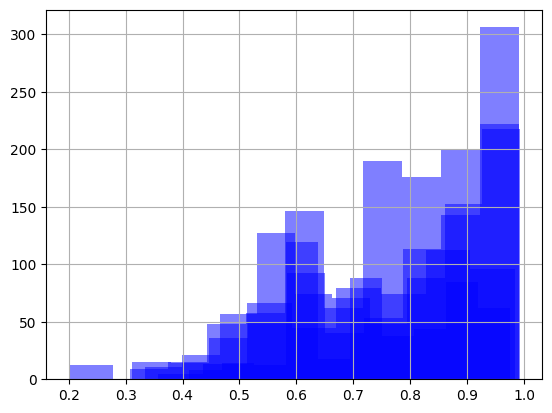

In [368]:
transparent_histogram(df_fire)

Die Reviewtexte mit sehr niedrigen Werten beim Main Topic, werden erstmal entfernt, damit nur Texte mit starken Gewichtungen in die Analyse kommen. 
Die Grenze wird bei 0.5 gesetzt, sprich der Artikel soll zur Mehrheit zu einem Thema gehören.

In [369]:
df_fire = df_fire[df_fire['mainscore'] > 0.5]
df_fire['maintopic'].value_counts().sort_values()

3     473
0     475
2     722
4     808
1    1152
Name: maintopic, dtype: int64

Thema 1 hat besonders viele zugeordnete Reviewtexte.
Dies kann sich darauf zurückführen lassen, dass zum einen das Wort 'fire' mit 1 gewichtet ist und zum anderen es alles Wörter sind, welche den Artikel an sich beschreiben. Viele Reviews werden wahrscheinlich darüber schreiben, wie sie den Feuerstarter benutzt haben.

In [388]:
print('Thema 1: Beschreibung / Bedienung des Feuerstarters')
print(df_topic_fire.loc[df_topic_fire.index[1]].loc[lambda x : x > 0.8].sort_values(ascending=False))

Thema 1: Beschreibung / Bedienung des Feuerstarters
magnesium    1.000000
fire         1.000000
make         1.000000
starter      1.000000
light        1.000000
like         1.000000
spark        0.942575
flint        0.930084
Name: 1, dtype: float64


### Overall und MainTopic

In [389]:
for i in range(5):
    avg = df_fire.loc[df_fire['maintopic'] == i, 'overall'].mean()
    print('Thema ',i, ' hat eine durchschnittliche Bewertung von ', avg)

Thema  0  hat eine durchschnittliche Bewertung von  4.434599156118144
Thema  1  hat eine durchschnittliche Bewertung von  4.220767888307155
Thema  2  hat eine durchschnittliche Bewertung von  4.254495159059474
Thema  3  hat eine durchschnittliche Bewertung von  4.408898305084746
Thema  4  hat eine durchschnittliche Bewertung von  3.7460122699386504


In den Durchschnittswerten von 'overall' ist auffällig, dass Thema 4 im Vergleich niedrigere Bewertungen erhalten haben. Um eine genauere Aufteilung zu sehen, werden die Anzahl an 1* und 5* Reviews mit der Gesamtzahl an Reviews in diesen Topic verglichen.

In [372]:
for i in range(5):
    print('Thema ',i)
    counts = df_fire.loc[df_fire['maintopic'] == i, 'overall'].value_counts()
    low = counts[1]/counts.sum()
    high = counts[5]/counts.sum()
    # print(df_fire.loc[df_fire['maintopic'] == i, 'overall'].value_counts().sum())
    print('Anteil von 1*: ',round(low*100, 2),'%')
    print('Anteil von 5*: ',round(high*100,2),'%')

Thema  0
Anteil von 1*:  2.32 %
Anteil von 5*:  64.0 %
Thema  1
Anteil von 1*:  6.86 %
Anteil von 5*:  59.64 %
Thema  2
Anteil von 1*:  6.37 %
Anteil von 5*:  63.71 %
Thema  3
Anteil von 1*:  3.59 %
Anteil von 5*:  68.5 %
Thema  4
Anteil von 1*:  11.14 %
Anteil von 5*:  39.6 %


Hier wird deutlich, dass Thema 4 besonders viele schlechte Bewertungen erhalten hat mit 11.14% und nur 39.6% mit sehr guter Bewertung.
Im Vergleich dazu haben Thema 0 und 3 sehr viele gute Bewertungen und relativ wenige schlechte.

In den nächsten Teil soll Thema 4 näher betrachtet werden um vielleicht den Grund für die Bewertungen zu finden.


### Thema 4

In [392]:
df_fire_topic_4 = df_fire.loc[(df_fire['maintopic'] == 4)]
df_fire_topic_4_bad = df_fire_topic_4.loc[(df_fire['overall'] == 1)]
print('Bad Reviews')
for i in range(3):
    print('Text ',i,':', df_fire_topic_4_bad.iloc[i]['reviewText'], '(Rating ', df_fire_topic_4_bad.iloc[i]['overall'],')')
print('\n Good Reviews')
df_fire_topic_4_good = df_fire_topic_4.loc[(df_fire['overall'] == 5)]
for i in range(3):
    print('Text ',i,':', df_fire_topic_4_good.iloc[i]['reviewText'], '(Rating ', df_fire_topic_4_good.iloc[i]['overall'],')')


Bad Reviews
Text  0 : cheap imitation doesnt spark at all with the striker hardly sparks even with a sharp knife  the magnesium block is too thick and flint is too thin often preventing a good strike of the flint (Rating  1 )
Text  1 : broke and 'magnesium' was aluminum and would not light even with torch lighter rod fell off after 3 strikes (Rating  1 )
Text  2 : i bought this for a survival bag and wanted to try it lighting a fire in my fire pit it never did ignite when i made a pile of shavings and put sparks on the pile don't know if it even is magnesium as magnesium is highly flammable (Rating  1 )

 Good Reviews
Text  0 : gets the job done  glad to have it (Rating  5 )
Text  1 : i love how compact this little tool is and that it actually does a good job of sparking some tinder so i can get my fire going  5 gold stars ;) (Rating  5 )
Text  2 : grandson loves it (Rating  5 )


Die negativen Reviews beschreiben, wie der Feuerstarter nicht funktioniert hat und begründen es mit einer Beschreibung des Artikels.
Die positiven Reviews beschreiben, wie der Feuerstarter doch funktioniert 

<function matplotlib.pyplot.show(close=None, block=None)>

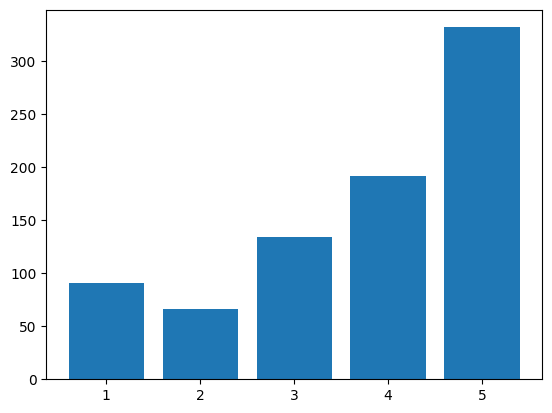

In [399]:
overall_4 = df_fire_topic_4['overall'].value_counts()
x = overall_4.index
y = overall_4.values

plt.bar(x, y)
plt.show

In der Verteilung der Werte von 'overall' ist erkennbar, dass trotz der schlechteren Durchschnittsbewertung, die meisten eine 5* Bewertung da gelassen haben.
Dennoch ist auch sichtbar, dass das Mittelfeld stark vertreten ist und es sogar mehr 1* als 2* Bewertungen gibt.

Ein weiterer Teil der geprüft werden kann, ist welche Adjektive genutzt wurden innerhalb eines Reviews.

In [400]:
topic_4_adjectives = []

def get_adjectives_in_list(elem):
    topic_4_adjectives.extend(elem)

df_fire_topic_4['adjectives'].apply(get_adjectives_in_list)

Counter(topic_4_adjectives).most_common(10)

[('good', 280),
 ('one', 165),
 ('little', 160),
 ('like', 130),
 ('would', 124),
 ('well', 123),
 ('great', 112),
 ('small', 106),
 ('nice', 96),
 ('even', 90)]

Etwas was nicht erkennbar ist aus dieser Analyse, ist ob das Adjektiv direkt oder verneint benutzt wurde. Deswegen ist es schwierig ein direktes Sentiment daraus zu erkennen.

## LDAMulticore - Substantive

Zuletzt wird ein kurzer Blick in die Substantive der Reviews geworfen in der Hoffnung deutlichere Topics zu sehen.

In [402]:
data_fire_sub = df_fire.nouns.values.tolist()
id2word_fire_sub = corpora.Dictionary(data_fire_sub)
corpus_fire_sub = [id2word_fire_sub.doc2bow(elem) for elem in data_fire_sub]
lda_model_fire_sub = gensim.models.LdaMulticore(corpus=corpus_fire_sub, id2word=id2word_fire_sub, num_topics=5, passes=20)

In [406]:
for i in range(3):
    bow_sub = id2word_fire_sub.doc2bow(df_fire.iloc[i]['reviewText_tokenize'])
    docu_topics_sub = lda_model_fire_sub.get_document_topics(bow_sub)

    print(i+1,'. Reviewtext: ', df_fire.iloc[i]['nouns'])
    for top in docu_topics_sub:
        print('Thema ',top[0],': ', top[1]*100,'%')
    print()

1 . Reviewtext:  ['fire', 'starter', 'work', 'instructions', 'day', 'fire', 'time']
Thema  0 :  1.8463190644979477 %
Thema  1 :  75.98649859428406 %
Thema  2 :  1.841898262500763 %
Thema  3 :  18.482783436775208 %
Thema  4 :  1.8424993380904198 %

2 . Reviewtext:  ['promise', 'bug', 'bag']
Thema  0 :  4.005338624119759 %
Thema  1 :  24.118690192699432 %
Thema  2 :  63.87256979942322 %
Thema  3 :  4.000882804393768 %
Thema  4 :  4.002519324421883 %

3 . Reviewtext:  ['work', 'thats', 'thing', 'hand', 'pocket', 'everything', 'fire', 'thats', 'end', 'afford', 'pay', 'option', 'work']
Thema  0 :  8.797509968280792 %
Thema  1 :  36.55913770198822 %
Thema  3 :  19.539928436279297 %
Thema  4 :  34.26147997379303 %



In [413]:
df_topic_fire_sub = create_df_normalize(lda_model_fire_sub,id2word_fire_sub ,5)
df_topic_fire_sub

,work,practice,lot,fire,magnesium,use,time,start,junk,buy,...,scrape,pile,link,striker,knife,chain,thing,tinder,blade,piece
0,0.054190,1.0,1.0,0.000000,0.262251,0.000000,0.624003,0.526477,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.0,0.0,1.000000,0.000000,0.148148,1.000000,1.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.160222,0.0,0.0,0.238714,0.000000,0.539678,0.000000,0.537900,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035575,0.0,0.0,0.593169,1.000000,0.940853,0.346735,0.000000,0.0,0.628099,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.504446,0.990441,1.000000,0.574127,0.929168,0.0,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [417]:
topic_name_2 = ['Bewertung','Beschreibung / Bedienung des Feuerstarters','Camping','Beschreibung / Bedienung des Feuerstarters','Beschreibung / Bedienung des Feuerstarters']
for i in range(5):
    print('Thema ',i,':',topic_name_2[i])
    print(round(df_topic_fire_sub.loc[df_topic_fire_sub.index[i]].loc[lambda x : x > 0.8].sort_values(ascending = False)),2)
    print()

Thema  0 : Bewertung
practice       1.0
lot            1.0
junk           1.0
buy            1.0
job            1.0
gift           1.0
love           1.0
mag            1.0
box            1.0
emergencies    1.0
stick          1.0
scout          1.0
Name: 0, dtype: float64 2

Thema  1 : Beschreibung / Bedienung des Feuerstarters
work         1.0
fire         1.0
time         1.0
start        1.0
product      1.0
price        1.0
item         1.0
starter      1.0
pack         1.0
quality      1.0
need         1.0
advertise    1.0
describe     1.0
order        1.0
ship         1.0
something    1.0
Name: 1, dtype: float64 2

Thema  2 : Camping
match        1.0
camp         1.0
try          1.0
emergency    1.0
bag          1.0
kit          1.0
purchase     1.0
tool         1.0
bug          1.0
backpack     1.0
case         1.0
addition     1.0
trip         1.0
Name: 2, dtype: float64 2

Thema  3 : Beschreibung / Bedienung des Feuerstarters
magnesium    1.0
bar          1.0
size         1.0

Auch hier ist es wieder schwierig, konkrete Namen oder Beschreibungen für die Themen zu finden. Was ebenfalls auffällt ist, dass manche Wörter bei verschiedenen Themen eine Gewichtung von 1 haben. Der ursprüngliche Wert muss in diesen Fällen identisch gewesen sein.